In [33]:
import src.get_data as get_data
import src.load_data as load
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import datetime 

from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import time
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8


import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

WINDOW = 50


In [2]:

def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    model.summary()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

In [69]:

def next5minutePrediction(typeBlockchain, stock):    
    
    df = get_data.get_data_frame5minutes()
    df = df[['open', 'low', 'high', 'close','volume', 'date_time']][-int(df.shape[0]/ 8 * 3):]
    df.index = df.date_time
    df = df.sort_index()

    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    all_df = df.copy()

    x = all_df[['low', 'high']].copy()

    y = all_df['close'].copy()

    #x = pd.ewma(x,2)
    #y = pd.ewma(y,2)

    x[['low', 'high']] = x_scaler.fit_transform(x)

    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
    #x['close'] = y
    shape = x.shape[1]
    #X_train, y_train = load.load_data(x, WINDOW, TrainTest = False)
    X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.90, TrainTest = True)

    model = build_model(input_shape=(WINDOW, shape))

    print('START FIT MODEL...')

    start = time.time()

    history = History()
    history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32, epochs=500,verbose=1,
              callbacks=[history])

    #model.fit(X_train, y_train, batch_size=128, epochs=200, verbose=1)
    end = time.time()

    print ('Learning time: ', end-start)

    today = time.strftime("_%d_%m_%Y")

    pathModel = "../../models/model_SHORT_" + typeBlockchain + today +".h5"
    #save_model(model, pathModel)
    #model = load_model(pathModel)
    
    # one day prediction. get last batch known data (now we didnt need in y value and can predict it)    
    lastbatch = np.array(x[-WINDOW:])
    pred = model.predict([lastbatch.reshape(1,WINDOW, shape)])
    pred =  np.array(y_scaler.inverse_transform(pred)) # predicted value

    # now we make dataframe and create row names in date

    splitStr = str(df.date_time[df.last_valid_index()]).split(' ')
    lastDate =splitStr[0].split('-')
    lastTime = splitStr[1].split(':')

    predictionDate = datetime.datetime(int(lastDate[0]),int(lastDate[1]),int(lastDate[2]),\
                                    int(lastTime[0]), int(lastTime[1]))  + datetime.timedelta(minutes=5)

    predictionDate = pd.date_range(predictionDate, periods=1)

    prediction = pd.DataFrame(pred, columns=["predictionPrice"], index = predictionDate.values)

    print (prediction)

    plot = True
    plotHictory = True
    interactiveGrapth = True

    if plot:
        trainPredict = model.predict(X_train)
        testPredict = model.predict(X_test)

        trainPredict = y_scaler.inverse_transform(trainPredict)
        trainY = y_scaler.inverse_transform([y_train])

        testPredict = y_scaler.inverse_transform(testPredict)
        testY = y_scaler.inverse_transform([y_test])

        trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
        print('Train Score: %.2f RMSE' % (trainScore))

        testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
        print('Test Score: %.2f RMSE' % (testScore))
        prices = df.close.values.astype('float32')
        prices = prices.reshape(len(prices), 1)
        trainPredictPlot = np.empty_like(prices)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

        testPredictPlot = np.empty_like(prices)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[(len(prices) - testPredict.shape[0]):len(prices), :] = testPredict

        plt.plot(pd.DataFrame(prices, columns=["close"]).close, label='Actual')
        plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"]).close, label='Training')
        plt.plot(pd.DataFrame(testPredictPlot, columns=["close"]).close, label='Testing')
        plt.legend(loc='best')
        plt.show()

        interactiveGrapth = 1
        if interactiveGrapth:


            prices = prices[-500:]
            trainPredictPlot = trainPredictPlot[-500:]
            testPredictPlot = testPredictPlot[-500:]

            Actual = pd.DataFrame(prices, columns=["close"]).close
            Training = pd.DataFrame(trainPredictPlot, columns=["close"]).close
            Testing = pd.DataFrame(testPredictPlot, columns=["close"]).close

            #Actual.to_csv('Actual.csv')
            #Training.to_csv('Training.csv')
            #Testing.to_csv('Testing.csv')

            ActualValues = go.Scatter( x = df.date_time[-500:], y = Actual, name = 'ActualValues')
            TrainingValues = go.Scatter( x = df.date_time[-500:], y = Training, name = 'TrainingValues')
            TestingValues = go.Scatter( x = df.date_time[-500:], y = Testing, name = 'PredictedValues')

            iplot([ActualValues,TrainingValues, TestingValues])
            plt.show()
        if plotHictory:

            plt.plot(history.history['loss'], label = 'TrainLoss')
            plt.plot(history.history['val_loss'], label = 'TestLoss')
            plt.legend()
            plt.show()
    return prediction

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50, 128)           67072     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 202,817.0
Trainable params: 202,817.0
Non-trainable params: 0.0
________________________________________________________________

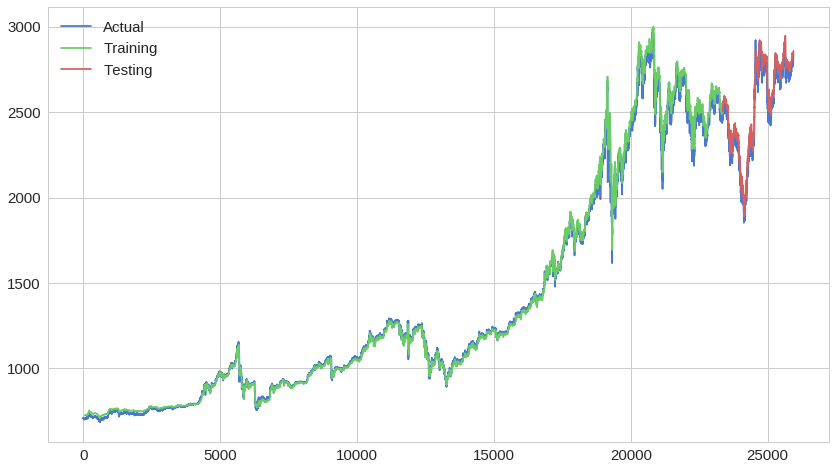

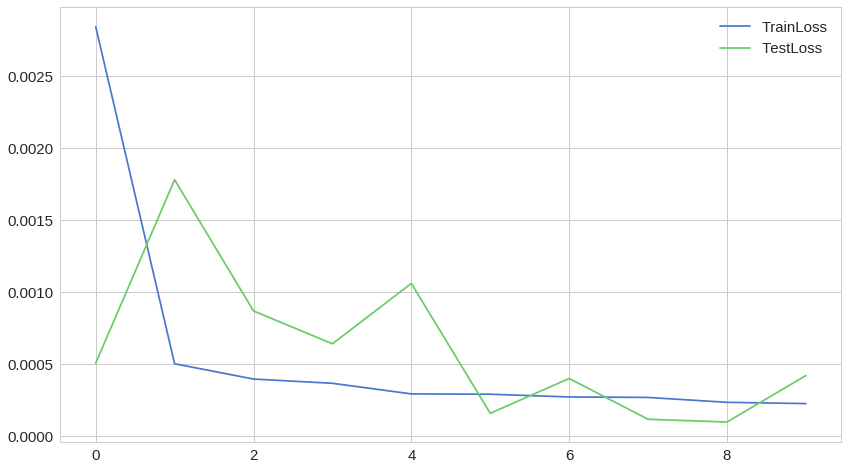

In [70]:
USDT_BTC = next5minutePrediction('USDT_BTC', 'poloniex' )